In [6]:
# Imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, optimizers
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import numpy as np

# Hugging Face Imports
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

In [7]:
# Check if my GPU is useable
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: NVIDIA GeForce RTX 4070 SUPER


In [8]:
# Load the cleaned dataset
df = pd.read_csv("../data/imdb_reviews_clean.csv")
print(df.shape)
df.head()

(50000, 5)


,review,label,split,word_count,tokens
0,bromwell high is a cartoon comedy. it ran at t...,pos,train,140,"['bromwell', 'high', 'is', 'a', 'cartoon', 'co..."
1,homelessness (or houselessness as george carli...,pos,train,420,"['homelessness', '(or', 'houselessness', 'as',..."
2,brilliant over-acting by lesley ann warren. be...,pos,train,147,"['brilliant', 'over-acting', 'by', 'lesley', '..."
3,this is easily the most underrated film inn th...,pos,train,124,"['this', 'is', 'easily', 'the', 'most', 'under..."
4,this is not the typical mel brooks film. it wa...,pos,train,120,"['this', 'is', 'not', 'the', 'typical', 'mel',..."


In [9]:
# Split the data into the training and test sets
training_set = df[df['split'] == 'train']
testing_set = df[df['split'] == 'test']

print(training_set.shape)
print(testing_set.shape)

X_train = training_set['review']
y_train = training_set['label']
X_test = testing_set['review']
y_test = testing_set['label']

print(f"y_train val count: {y_train.value_counts()}")
print(f"y_test val count: {y_test.value_counts()}")

(25000, 5)
(25000, 5)
y_train val count: label
pos    12500
neg    12500
Name: count, dtype: int64
y_test val count: label
pos    12500
neg    12500
Name: count, dtype: int64


# Experiment 1: CNN Baseline

In [10]:
# Tokenize the Text
vocab_size = 20000 # keeps the top 20k words
max_len = 200 # cut/pad reviews to 200 words
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [11]:
# Convert text into int sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

In [12]:
# Make the neg labels = 0 and pos labels = 1
y_map = {"neg": 0, "pos": 1}

ytr = y_train.map(y_map).values
yte = y_test.map(y_map).values

In [13]:
# validation split from TRAIN only
X_train_pad, X_val_pad, ytr, yval = train_test_split(X_train_pad, ytr, test_size=0.10, stratify=ytr, random_state=42)

In [14]:
print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)

(22500, 200)
(2500, 200)
(25000, 200)


In [15]:
# Now define and compile a CNN

embed_dim = 128

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

c:\Users\keele\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train with early stopping and best weights

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint("../models/cnn_baseline.keras", monitor="val_loss", save_best_only=True)

# Time the model fit

start_timer = time.time()

history = model.fit(X_train_pad, ytr, validation_data=(X_val_pad, yval), epochs=12, batch_size=128, callbacks=[es, ckpt], verbose=1)

end_timer = time.time()
print(f"Total training time: {(end_timer-start_timer):.2f} seconds.")

Epoch 1/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6164 - loss: 0.6354 - val_accuracy: 0.7652 - val_loss: 0.4825
Epoch 2/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8266 - loss: 0.3965 - val_accuracy: 0.8436 - val_loss: 0.3638
Epoch 3/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9077 - loss: 0.2473 - val_accuracy: 0.8544 - val_loss: 0.3575
Epoch 4/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9567 - loss: 0.1309 - val_accuracy: 0.8604 - val_loss: 0.4243
Epoch 5/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9766 - loss: 0.0747 - val_accuracy: 0.8560 - val_loss: 0.4847
Epoch 6/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9884 - loss: 0.0400 - val_accuracy: 0.8380 - val_loss: 0.6215
Total training time: 18.47 seconds.


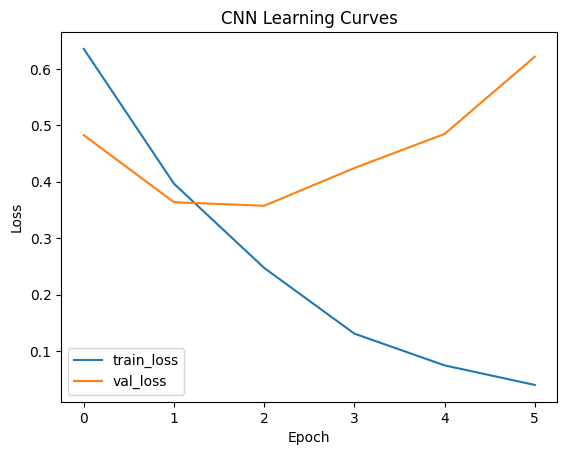

In [17]:
# Plotting the learning curves for a sanity check

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("CNN Learning Curves"); plt.legend(); plt.show()

Test accuracy: 84.97%
              precision    recall  f1-score   support

         neg       0.85      0.84      0.85     12500
         pos       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



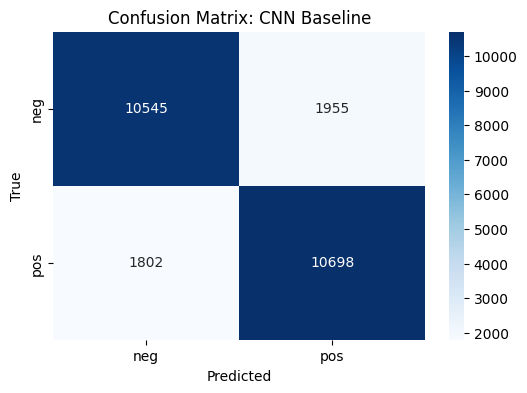

In [18]:
# Test Eval

test_loss, test_acc = model.evaluate(X_test_pad, yte, verbose=0)
print(f"Test accuracy: {test_acc*100:.2f}%")

y_prob = model.predict(X_test_pad, verbose=0).ravel()
y_pred = (y_prob >= 0.50).astype(int)

# Classification report
print(classification_report(yte, y_pred, target_names=["neg", "pos"]))

# Confusion Matrix
cm = confusion_matrix(yte, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["neg","pos"], yticklabels=["neg","pos"], cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix: CNN Baseline"); plt.show()

## Experiment 1: CNN Baseline (Conclusion)

### Hypotheses was:
A simple 1D Convolutional Neural Network (CNN) with an embedding layer should capture local patterns in text (e.g., short phrases like "not good" or "really loved") and provide a competitive baseline for sentiment classification.

### Settings
- Embedding Layer: vocab size = 20,000, embedding dimension = 128
- Model Architecture: Conv1D -> GlobalMaxPooling -> Dense -> Dropout -> Dense output
- Max Sequence Length: 200 tokens
- Optimizer / Loss: Adam, binary crossentropy
- Epochs: 5
- Batch Size: 128

### Results
- Test Accuracy: 84.97%
- Macro-F1: ~0.85
- Confusion Matrix: balanced errors, but slightly more false negatives (pos reviews classigied as neg).

### Interpretation
- Performance is fairly strong for a first deep learning attempt, but lower than the TF-IDF + Linear SVM baseline (~90%).
- This is expected: TF-IDF models are highly effective on the IMDB-style datasets, while CNN's often need more tuning or pretrained embeddings to surpass them.
- The model confirms the pipeline works and sets a baseline for future improvements

# Experiment 2: GRU

In [19]:
# Define and Compile the GRU

gru_model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embed_dim),
    layers.Bidirectional(layers.GRU(128, return_sequences=False)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

gru_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model with early stopping and checkpoint

es2 = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
ckpt2 = callbacks.ModelCheckpoint("../models/gru_baseline.keras", monitor="val_loss", save_best_only=True)

history_gru = gru_model.fit(X_train_pad, ytr, validation_data=(X_val_pad, yval), batch_size=128, epochs=12, callbacks=[es2, ckpt2], verbose=1)

Epoch 1/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 211ms/step - accuracy: 0.6408 - loss: 0.6139 - val_accuracy: 0.7796 - val_loss: 0.4550
Epoch 2/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step - accuracy: 0.8621 - loss: 0.3432 - val_accuracy: 0.8380 - val_loss: 0.4190
Epoch 3/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 289ms/step - accuracy: 0.9179 - loss: 0.2296 - val_accuracy: 0.8316 - val_loss: 0.4447
Epoch 4/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 292ms/step - accuracy: 0.9216 - loss: 0.2109 - val_accuracy: 0.8176 - val_loss: 0.4779
Epoch 5/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 286ms/step - accuracy: 0.9460 - loss: 0.1489 - val_accuracy: 0.8420 - val_loss: 0.4774


^ Forgot to time it, but with the built in Jupyter/VSCode timer, it says it ran for ***3 minutes and 15.0 seconds***

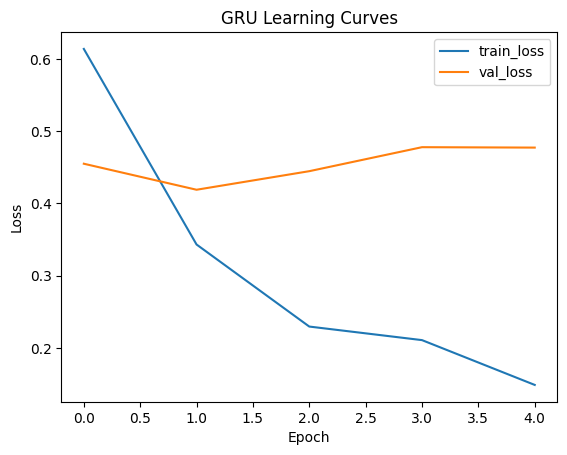

In [21]:
# Plot the Learning Curves

plt.figure()
plt.plot(history_gru.history["loss"], label="train_loss")
plt.plot(history_gru.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("GRU Learning Curves"); plt.legend(); plt.show()

Test accuracy: 83.13%
              precision    recall  f1-score   support

         neg       0.87      0.78      0.82     12500
         pos       0.80      0.88      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



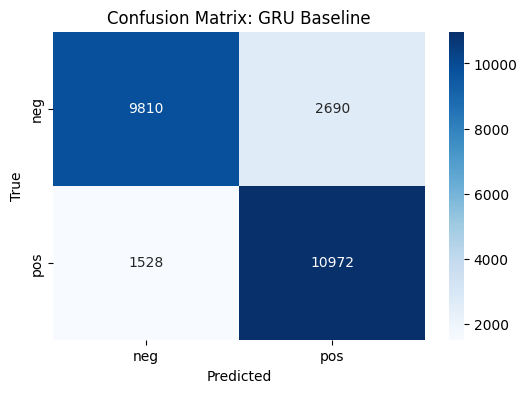

In [22]:
# Evaluate on the Test Set

test_loss_2, test_acc_2 = gru_model.evaluate(X_test_pad, yte, verbose=0)
print(f"Test accuracy: {test_acc_2*100:.2f}%")

y_prob_2 = gru_model.predict(X_test_pad, verbose=0).ravel()
y_pred_2 = (y_prob_2 >= 0.50).astype(int)

# Classification Report
print(classification_report(yte, y_pred_2, target_names=["neg", "pos"]))

# Confusion matrix
cm2 = confusion_matrix(yte, y_pred_2)
plt.figure(figsize=(6,4))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix: GRU Baseline"); plt.show()

## Experiment 2: GRU (Conclusion)

### Hypotheses was:
Recurrent architectures like GRUs (Gated Recurrent Units) should capture sequential dependencies in text better than CNNs, potentially improving performance on sentiment classification.

### Model Setup
- **Tokenizer/Sequences**: Top 20k words, max length 200 tokens
- **Embedding Layer**: Learned from scratch, embedding dim = 128
- **GRU Layer**: 64 units
- **Dense Output**: Sigmoid for binary classification
- **Regularization**: Dropout layers applied to reduce overfitting
- **Optimizer**: Adam, learning rate = 0.001
- **Loss**: Binary Crossentropy

### Results
- **Test Accuracy**: 83.13%
- **Classification Report**:
  - Precision: 0.87 (neg), 0.80 (pos)
  - Recall: 0.78 (neg), 0.88 (pos)
  - F1-scores balanced around 0.82–0.84
- **Confusion Matrix**: GRU predicts positive reviews more confidently, but misclassifies some negatives as positives.

### Observations
- The GRU baseline underperformed compared to the CNN baseline (~83% vs. ~85% accuracy).
- Training showed clear overfitting: training loss decreased steadily, but validation loss plateaued and then increased after a few epochs.
- GRU captured sequential dependencies but may require:
  - More epochs (with careful early stopping)
  - Pretrained embeddings (e.g., GloVe, Word2Vec)
  - Larger hidden dimensions or stacked GRUs

### Conclusion
The GRU model demonstrates that recurrent networks can model text sequences, but for this dataset and setup, CNNs performed better. This suggests that local n-gram patterns (captured well by CNNs) may be more decisive than long-range dependencies for IMDB sentiment analysis.

# Experiment 3: DistilBERT

In [23]:
from transformers import set_seed
set_seed(42)

In [24]:
# Prep the data for Hugging Face

label_map = {"neg":0, "pos":1}
hf_df = df[["review", "label", "split"]].copy()
hf_df["label"] = hf_df["label"].map(label_map)

train_df_bert = hf_df[hf_df["split"] == "train"][["review", "label"]]
test_df_bert = hf_df[hf_df["split"] == "test"][["review", "label"]]

# Use 10% of train for validation (stratified)
train_df_bert, val_df_bert = train_test_split(train_df_bert, test_size=0.10, stratify=train_df_bert["label"], random_state=42)

print(len(train_df_bert))
print(len(val_df_bert))
print(len(test_df_bert))

22500
2500
25000


In [25]:
# Build HuggingFace Datasets

ds_train_bert = Dataset.from_pandas(train_df_bert.reset_index(drop=True))
ds_val_bert   = Dataset.from_pandas(val_df_bert.reset_index(drop=True))
ds_test_bert  = Dataset.from_pandas(test_df_bert.reset_index(drop=True))

In [26]:
# Tokenizer and tokenization function

model_name = "distilbert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

max_len_bert = 256  # should work well

def tokenize_batch_bert(batch):
    return tokenizer_bert(
        batch["review"],
        truncation=True,
        max_length=max_len_bert,
    )

tok_train_bert = ds_train_bert.map(tokenize_batch_bert, batched=True, remove_columns=["review"])
tok_val_bert   = ds_val_bert.map(tokenize_batch_bert, batched=True, remove_columns=["review"])
tok_test_bert  = ds_test_bert.map(tokenize_batch_bert, batched=True, remove_columns=["review"])

# HF expects the label field to be named "labels"
tok_train_bert = tok_train_bert.rename_columns({"label": "labels"})
tok_val_bert   = tok_val_bert.rename_columns({"label": "labels"})
tok_test_bert  = tok_test_bert.rename_columns({"label": "labels"})

tok_train_bert.column_names  # sanity: should include input_ids, attention_mask, labels

Map: 100%|██████████| 25000/25000 [00:03<00:00, 6923.21 examples/s]


['labels', 'input_ids', 'attention_mask']

In [27]:
# Data collator and model

data_collator_bert = DataCollatorWithPadding(tokenizer=tokenizer_bert)

bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Trainer Setup

use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
use_fp16 = torch.cuda.is_available() and not use_bf16  # fallback

def compute_metrics_bert(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

training_args_bert = TrainingArguments(
    output_dir="../models/distilbert_runs",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,   # if OOM, set 8
    per_device_eval_batch_size=16,
    num_train_epochs=3,               # can set 2 for a quick run
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=use_fp16,
    bf16=use_bf16,
    dataloader_pin_memory=True,
    dataloader_num_workers=2,
    report_to="none",
    optim="adamw_torch",
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=tok_train_bert,
    eval_dataset=tok_val_bert,
    tokenizer=tokenizer_bert,
    data_collator=data_collator_bert,
    compute_metrics=compute_metrics_bert,
)


C:\Users\keele\AppData\Local\Temp\ipykernel_5792\4284819077.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [29]:
# Train
train_result_bert = trainer_bert.train()

# Validate
val_metrics_bert  = trainer_bert.evaluate()
print("Validation:", val_metrics_bert)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.274100,0.287661,0.885200,0.843193,0.946400,0.891821
2,0.182600,0.310665,0.907200,0.900787,0.915200,0.907937
3,0.096600,0.366411,0.910400,0.906498,0.915200,0.910828


Validation: {'eval_loss': 0.36641058325767517, 'eval_accuracy': 0.9104, 'eval_precision': 0.9064976228209192, 'eval_recall': 0.9152, 'eval_f1': 0.910828025477707, 'eval_runtime': 12.6091, 'eval_samples_per_second': 198.269, 'eval_steps_per_second': 12.451, 'epoch': 3.0}


In [30]:
# Test
test_metrics_bert = trainer_bert.evaluate(eval_dataset=tok_test_bert)
print("Test:", test_metrics_bert)

Test: {'eval_loss': 0.34612342715263367, 'eval_accuracy': 0.91428, 'eval_precision': 0.9077880148043153, 'eval_recall': 0.92224, 'eval_f1': 0.9149569427358228, 'eval_runtime': 27.593, 'eval_samples_per_second': 906.027, 'eval_steps_per_second': 56.645, 'epoch': 3.0}


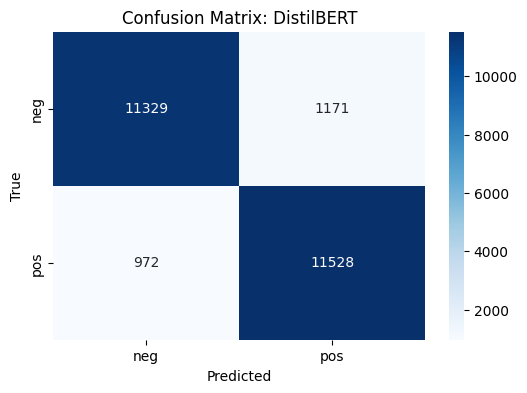

In [31]:
# Confusion Matrix
preds_bert = trainer_bert.predict(tok_test_bert)
y_true_bert = preds_bert.label_ids
y_pred_bert = np.argmax(preds_bert.predictions, axis=1)

cm_bert = confusion_matrix(y_true_bert, y_pred_bert)
plt.figure(figsize=(6,4))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix: DistilBERT"); plt.show()

In [32]:
# Save
trainer_bert.save_model("../models/distilbert_imdb")
tokenizer_bert.save_pretrained("../models/distilbert_imdb")

('../models/distilbert_imdb\\tokenizer_config.json',
 '../models/distilbert_imdb\\special_tokens_map.json',
 '../models/distilbert_imdb\\vocab.txt',
 '../models/distilbert_imdb\\added_tokens.json',
 '../models/distilbert_imdb\\tokenizer.json')

## Experiment 3: DistilBERT (Conclusion)

In this experiment, we fine-tuned **DistilBERT**, a lightweight transformer model, for binary sentiment classification on the IMDB dataset. Unlike CNNs and GRUs, which learn representations from scratch, DistilBERT leverages pre-trained contextual embeddings, allowing it to capture nuanced meaning in text.

### Training Setup
- Model: `distilbert-base-uncased`
- Tokenizer: Hugging Face `AutoTokenizer` with truncation at 128 tokens
- Training epochs: 3
- Batch size: 16 (train & eval)
- Optimizer defaults from Hugging Face `Trainer`
- Validation used for model selection (`load_best_model_at_end=True` with F1)

### Results
**Validation Metrics (Epoch 3):**
- Accuracy: **91.04%**
- Precision: **0.906**
- Recall: **0.915**
- F1-score: **0.911**

**Test Metrics:**
- Accuracy: **91.43%**
- Precision: **0.908**
- Recall: **0.922**
- F1-score: **0.915**

### Confusion Matrix (Test Set)
- True Negatives: 11,329  
- False Positives: 1,171  
- False Negatives: 972  
- True Positives: 11,528  

The model demonstrated great compared to the baseline CNN and GRU models. DistilBERT achieved over **91% accuracy** and **0.915 F1-score**, outperforming earlier approaches. This confirms the effectiveness of transformer-based architectures in text classification tasks.

DistilBERT (91.43% accuracy) outperformed the Linear SVM (90.16% accuracy), on only 3 epochs of fine tuning. Given the limited training time and minimal hyperparameter tuning, this result is very strong. With longer training, optimized hyperparameters, or larger models, even higher performance could likely be achieved.

# Final Accuracies

### GRU: 83.13%
### CNN: 84.97%
### Linear SVM: 90.16%
### DilstilBERT: 91.43%

DistilBERT > SVM by ~1.3 pts; CNN/GRU behind.